<a href="https://colab.research.google.com/github/rhaulmendonca/Acidentes-por-Aeronave/blob/main/Sistemas%20de%20Apoio%20%C3%A0%20Decis%C3%A3o/CENIPA_Acidentes_por_aeronave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pré-processamento de dados**

**Carregamento da fonte de dados no Google Drive**

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Instalação e carregamento de bibliotecas**

In [ ]:
pip install adjustText

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
pip install gmplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

import datetime
import calendar

from matplotlib.ticker import PercentFormatter
import geopandas as gpd
import re
import adjustText as aT
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import metrics

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost.utils import get_confusion_matrix
from catboost import cv

from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

**Carregamento de dados**

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Sistemas de Apoio a Decisão/126 - CENIPA - Acidentes por Aeronave.xlsx'
df = pd.read_excel(file_path)

**Conversão da variável "Hora da ocorrência" para decimal**

In [ ]:
# Garantir que a coluna é string e remover espaços extras
df['Hora da ocorrência'] = df['Hora da ocorrência'].astype(str).str.strip()

# Converter diretamente para decimal (exemplo: "14:30:00" → 14.5)
df['Horário do Acidente'] = df['Hora da ocorrência'].apply(lambda x: int(x[:2]) + int(x[3:5]) / 60 if ':' in x else np.nan)

# Verificar o resultado
print(df[['Hora da ocorrência', 'Horário do Acidente']].head(10))

  Hora da ocorrência  Horário do Acidente
0           20:00:00            20.000000
1           12:40:00            12.666667
2           15:00:00            15.000000
3           17:30:00            17.500000
4           20:00:00            20.000000
5           17:30:00            17.500000
6           10:33:00            10.550000
7           17:00:00            17.000000
8           11:27:00            11.450000
9           10:15:00            10.250000


# **Análise exploratória dos dados**

In [ ]:
num_rows, num_cols = df.shape
print("Número de linhas:", num_rows)
print("Número de colunas:", num_cols)


Número de linhas: 10397
Número de colunas: 55


In [ ]:
import os

# Obtendo o tamanho do arquivo em KB
file_size_kb = os.path.getsize(file_path) / 1024
print("Tamanho do arquivo (KB):", file_size_kb)


Tamanho do arquivo (KB): 2525.181640625


In [ ]:
df.info()  # Exibe informações sobre cada coluna e tipo de dado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10397 entries, 0 to 10396
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Código da ocorrência               10397 non-null  int64         
 1   Classificação da ocorrência        10397 non-null  object        
 2   Latitude da ocorrência             10397 non-null  float64       
 3   Longitude da ocorrência            10397 non-null  float64       
 4   Código IBGE do município           10397 non-null  int64         
 5   Nome do município                  10397 non-null  object        
 6   Código IBGE da microrregião        10397 non-null  int64         
 7   Nome da microrregiao               10397 non-null  object        
 8   Código IBGE da mesoregião          10397 non-null  int64         
 9   Nome da mesoregião                 10397 non-null  object        
 10  Código IBGE da UF                 

In [ ]:
df.head()


,Código da ocorrência,Classificação da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Nome do município,Código IBGE da microrregião,Nome da microrregiao,Código IBGE da mesoregião,Nome da mesoregião,...,Categoria de registro,Segmento de registro,Aeródromo de origem,Aeródromo de destino,Fase de operação,Nível de dano da aeronave,Total de fatalidades,Tipo de ocorrência,Categoria do tipo de ocorrência,Taxonomia do tipo ICAO
0,78640,ACIDENTE,-16.762062,-49.438403,5200050,Abadia de Goiás,52010,Goiânia,5203,Centro Goiano,...,ULTRALEVE,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,CRUZEIRO,SUBSTANCIAL,0,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
1,46633,ACIDENTE,-16.762062,-49.438403,5200050,Abadia de Goiás,52010,Goiânia,5203,Centro Goiano,...,AVIÃO,EXPERIMENTAL,FORA DE AERODROMO,FORA DE AERODROMO,MANOBRA,SUBSTANCIAL,0,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR | FALHA DO...,SCF-PP
2,80154,ACIDENTE,-1.962741,-48.196593,1500206,Acará,15012,Tomé-Açu,1504,Nordeste Paraense,...,AVIÃO,PARTICULAR,NÃO IDENTIFICADO,NÃO IDENTIFICADO,Sem Informação,LEVE,0,INDETERMINADO,INDETERMINADO,UNK
3,38855,ACIDENTE,-31.867518,-54.163801,4300034,Aceguá,43031,Campanha Meridional,4306,Sudoeste Rio-grandense,...,AVIÃO,ESPECIALIZADA,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,SUBSTANCIAL,1,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I
4,50831,ACIDENTE,-17.400018,-50.379307,5200134,Acreúna,52014,Vale do Rio dos Bois,5205,Sul Goiano,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,DECOLAGEM,DESTRUÍDA,4,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I


In [ ]:
df.dtypes


,0
Código da ocorrência,int64
Classificação da ocorrência,object
Latitude da ocorrência,float64
Longitude da ocorrência,float64
Código IBGE do município,int64
Nome do município,object
Código IBGE da microrregião,int64
Nome da microrregiao,object
Código IBGE da mesoregião,int64
Nome da mesoregião,object


In [ ]:
def get_duplicates(df):
 coluna = [column for column in df.columns if 'Código da ocorrência' in column]
 coluna = coluna[0]
 duplicados = df.loc[df[coluna].duplicated()][coluna].values
 df_duplicados = df[df[coluna].isin(duplicados)].sort_values(by=coluna)
 return df_duplicados

In [ ]:
get_duplicates(df)

,Código da ocorrência,Classificação da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Nome do município,Código IBGE da microrregião,Nome da microrregiao,Código IBGE da mesoregião,Nome da mesoregião,...,Categoria de registro,Segmento de registro,Aeródromo de origem,Aeródromo de destino,Fase de operação,Nível de dano da aeronave,Total de fatalidades,Tipo de ocorrência,Categoria do tipo de ocorrência,Taxonomia do tipo ICAO
9905,31255,ACIDENTE,-24.166843,-54.096779,4127403,Terra Roxa,41022,Toledo,4106,Oeste Paranaense,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,CORRIDA APÓS POUSO,DESTRUÍDA,0,POUSO LONGO,EXCURSÃO DE PISTA | POUSO LONGO,RE
9907,31255,ACIDENTE,-24.166843,-54.096779,4127403,Terra Roxa,41022,Toledo,4106,Oeste Paranaense,...,AVIÃO,PARTICULAR,FORA DE AERODROMO,FORA DE AERODROMO,CORRIDA APÓS POUSO,DESTRUÍDA,0,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,LOC-G
2932,31875,INCIDENTE GRAVE,-15.600666,-56.097856,5103403,Cuiabá,51017,Cuiabá,5104,Centro-Sul Mato-grossense,...,AVIÃO,INSTRUÇÃO,MARECHAL RONDON,ESTÂNCIA SANTA RITA,DECOLAGEM,LEVE,0,PERDA DE CONTROLE NO SOLO,PERDA DE CONTROLE NO SOLO,LOC-G
2928,31875,INCIDENTE GRAVE,-15.600666,-56.097856,5103403,Cuiabá,51017,Cuiabá,5104,Centro-Sul Mato-grossense,...,AVIÃO,INSTRUÇÃO,MARECHAL RONDON,ESTÂNCIA SANTA RITA,DECOLAGEM,LEVE,0,EXCURSÃO DE PISTA,EXCURSÃO DE PISTA,RE
542,32916,ACIDENTE,-2.748361,-42.826727,2101707,Barreirinhas,21004,Lençóis Maranhenses,2101,Norte Maranhense,...,AVIÃO,TÁXI AÉREO,RANCHO SUMIDOR,RANCHO SUMIDOR,CORRIDA APÓS POUSO,SUBSTANCIAL,0,COLISÃO COM OBSTÁCULOS NO SOLO,COLISÃO NO SOLO | COLISÃO COM OBSTÁCULOS NO SOLO,GCOL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4612,82561,INCIDENTE GRAVE,-23.153000,-47.058000,3524006,Itupeva,35047,Jundiaí,3512,Macro Metropolitana Paulista,...,ULTRALEVE,EXPERIMENTAL,MURARO - SP,MURARO - SP,CRUZEIRO,LEVE,0,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
8902,82600,INCIDENTE,-25.532994,-49.183860,4125506,São José dos Pinhais,41037,Curitiba,4110,Metropolitana de Curitiba,...,AVIÃO,Sem Informação,HERCÍLIO LUZ,GOVERNADOR JOSÉ RICHA,CRUZEIRO,NENHUM,0,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
8900,82600,INCIDENTE,-25.532994,-49.183860,4125506,São José dos Pinhais,41037,Curitiba,4110,Metropolitana de Curitiba,...,AVIÃO,Sem Informação,HERCÍLIO LUZ,GOVERNADOR JOSÉ RICHA,CRUZEIRO,NENHUM,0,FOGO/FUMAÇA (SEM IMPACTO),FOGO/FUMAÇA (SEM IMPACTO),F-NI
8959,82874,ACIDENTE,-15.628746,-58.180367,5107107,São José dos Quatro Marcos,51014,Jauru,5103,Sudoeste Mato-grossense,...,AVIÃO,AGRÍCOLA,FORA DE AERODROMO,FORA DE AERODROMO,MANOBRA,SUBSTANCIAL,1,PERDA DE CONTROLE EM VOO,PERDA DE CONTROLE EM VOO,LOC-I


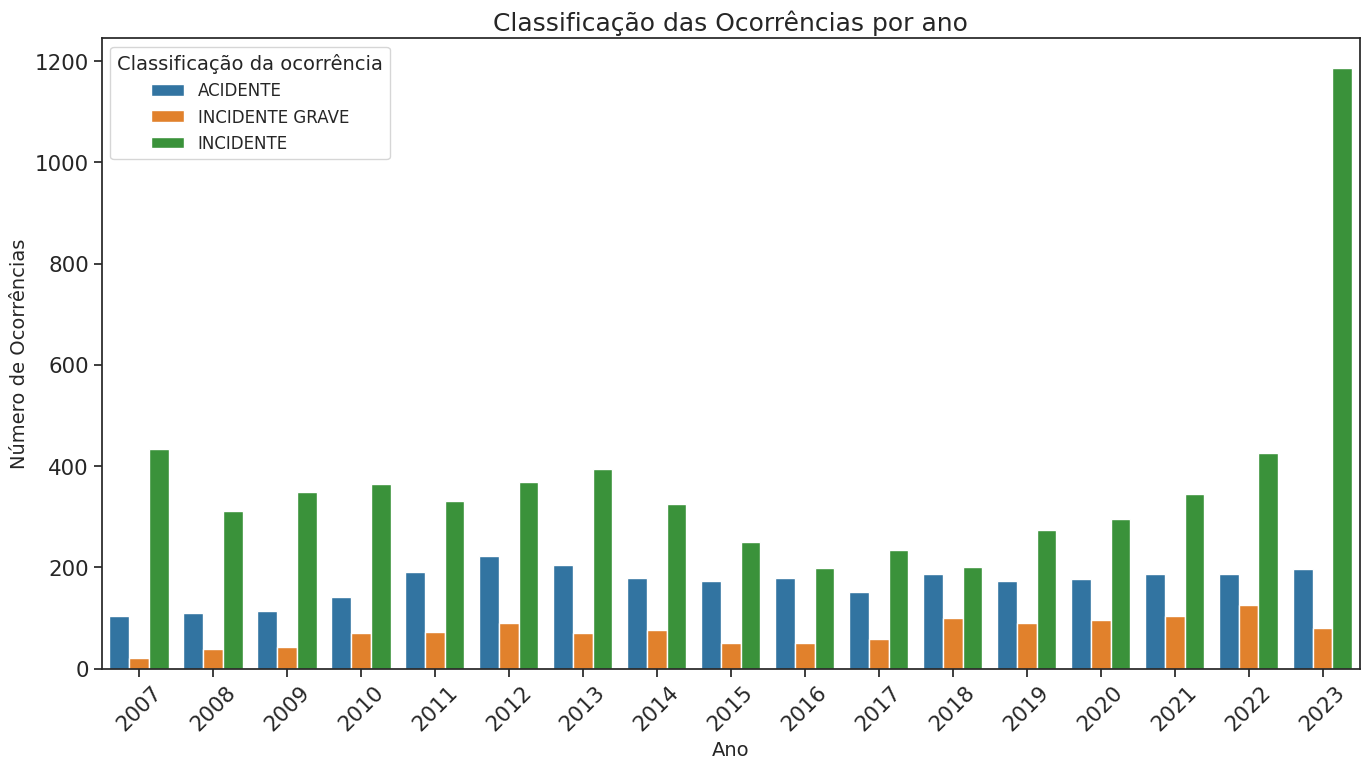

In [ ]:
# Configurações do gráfico
plt.figure(figsize=(14, 8))  # Tamanho do gráfico
sbn.set(font_scale=1.4)  # Ajustar o tamanho da fonte
sbn.set_style('ticks')  # Estilo de grade

# Definir nova ordem e paleta de cores
hue_order = ['ACIDENTE', 'INCIDENTE GRAVE', 'INCIDENTE']
palette = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Cores personalizadas (azul, laranja, verde)

# Gráfico de barras
sbn.countplot(
    data=df,
    hue='Classificação da ocorrência',
    x='Ano da ocorrência',
    palette=palette,  # Paleta de cores
    hue_order=hue_order  # Ordem personalizada
)

# Personalização dos eixos e título
plt.title('Classificação das Ocorrências por ano', fontsize=18)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Número de Ocorrências', fontsize=14)
plt.legend(title='Classificação da ocorrência', title_fontsize=14, fontsize=12)
plt.xticks(rotation=45)  # Girar os rótulos do eixo X para facilitar a leitura
plt.tight_layout()  # Ajustar os espaçamentos
plt.show()


<ipython-input-23-ae34d354fbac>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sbn.barplot(


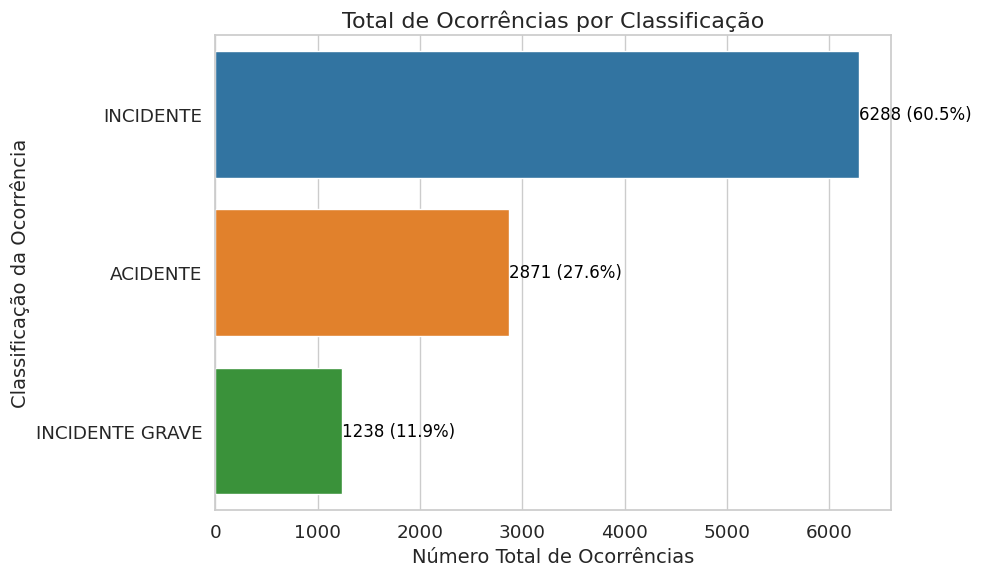

In [ ]:
# Contar as ocorrências por classificação
totais = df['Classificação da ocorrência'].value_counts().reset_index()
totais.columns = ['Classificação da ocorrência', 'Total']

# Calcular porcentagens
totais['Porcentagem'] = (totais['Total'] / totais['Total'].sum()) * 100

# Configurações do gráfico
plt.figure(figsize=(10, 6))
sbn.set(font_scale=1.2)
sbn.set_style('whitegrid')

# Gráfico de barras horizontais
ax = sbn.barplot(
    data=totais,
    x='Total',
    y='Classificação da ocorrência',
    palette=['#1f77b4', '#ff7f0e', '#2ca02c']  # Paleta de cores personalizadas
)

# Adicionar rótulos de dados com números e porcentagens
for index, row in totais.iterrows():
    ax.text(
        row['Total'] + 0.5, index,  # Posição do rótulo
        f"{row['Total']} ({row['Porcentagem']:.1f}%)",  # Texto do rótulo
        color='black', va='center', fontsize=12
    )

# Personalização dos eixos e título
plt.title('Total de Ocorrências por Classificação', fontsize=16)
plt.xlabel('Número Total de Ocorrências', fontsize=14)
plt.ylabel('Classificação da Ocorrência', fontsize=14)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
import pandas as pd
import folium
import numpy as np

# Extrair latitudes e longitudes
latitudes = df['Latitude da ocorrência'].tolist()
longitudes = df['Longitude da ocorrência'].tolist()

# Criar uma coluna que representa a contagem de ocorrências por latitude e longitude
df['Ocorrências'] = df.groupby(['Latitude da ocorrência', 'Longitude da ocorrência'])['Latitude da ocorrência'].transform('count')

# Filtrar para mostrar apenas locais com mais de 10 ocorrências
df_ocorrencias_filtrado = df[df['Ocorrências'] > 10]

# Criar o mapa centralizado na média das coordenadas com zoom ajustado
mapa = folium.Map(location=[
    df_ocorrencias_filtrado['Latitude da ocorrência'].mean(),
    df_ocorrencias_filtrado['Longitude da ocorrência'].mean()
], zoom_start=5)

# Adicionar marcadores ao mapa
for index, row in df_ocorrencias_filtrado.iterrows():
    folium.CircleMarker(
        location=[row['Latitude da ocorrência'], row['Longitude da ocorrência']],
        radius=max(row['Ocorrências'] / 10, 3),  # Reduzir e limitar o tamanho mínimo
        popup=f"Ocorrências: {row['Ocorrências']}",
        color='red' if row['Ocorrências'] > 100 else 'blue',  # Destacar locais críticos
        fill=True,
        fill_color='red' if row['Ocorrências'] > 100 else 'blue'
    ).add_to(mapa)

# Salvar o mapa como arquivo HTML
mapa.save('mapa_ocorrencias.html')

# Mensagem de conclusão
print("Mapa criado e salvo como 'mapa_ocorrencias.html'. Abra o arquivo no navegador para visualizar.")

from google.colab import files
# Baixar o arquivo HTML
files.download('mapa_ocorrencias.html')





Mapa criado e salvo como 'mapa_ocorrencias.html'. Abra o arquivo no navegador para visualizar.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

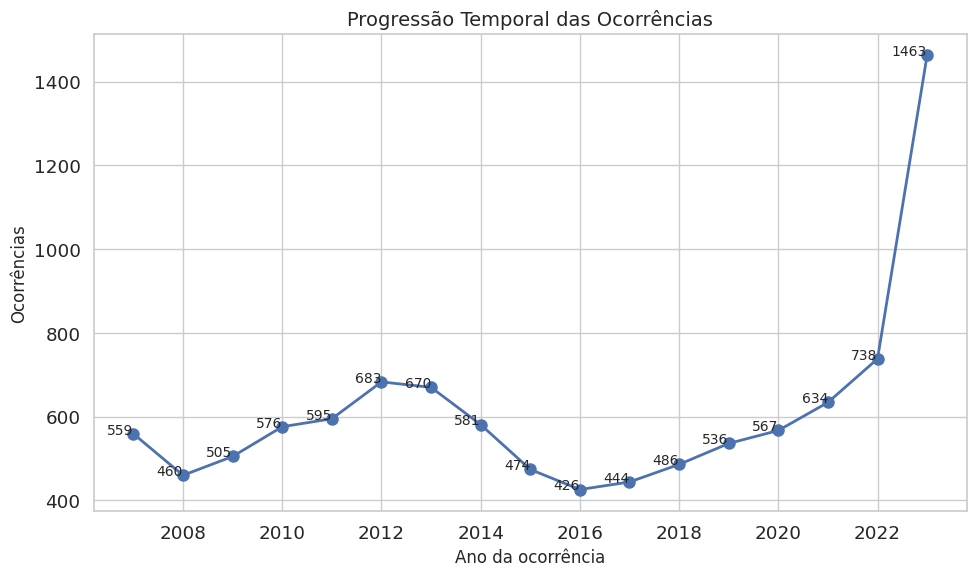

In [ ]:
# Contando o número de ocorrências por ano
df_grouped = df.groupby('Ano da ocorrência').size().reset_index(name='Ocorrências')

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Ano da ocorrência'], df_grouped['Ocorrências'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Adicionando título e rótulos aos eixos
plt.title('Progressão Temporal das Ocorrências', fontsize=14)
plt.xlabel('Ano da ocorrência', fontsize=12)
plt.ylabel('Ocorrências', fontsize=12)

# Exibindo as labels para cada ponto
for i, txt in enumerate(df_grouped['Ocorrências']):
    plt.text(df_grouped['Ano da ocorrência'].iloc[i], df_grouped['Ocorrências'].iloc[i], str(txt), fontsize=10, ha='right')

# Exibindo o gráfico
plt.grid(True)
plt.tight_layout()
plt.show()

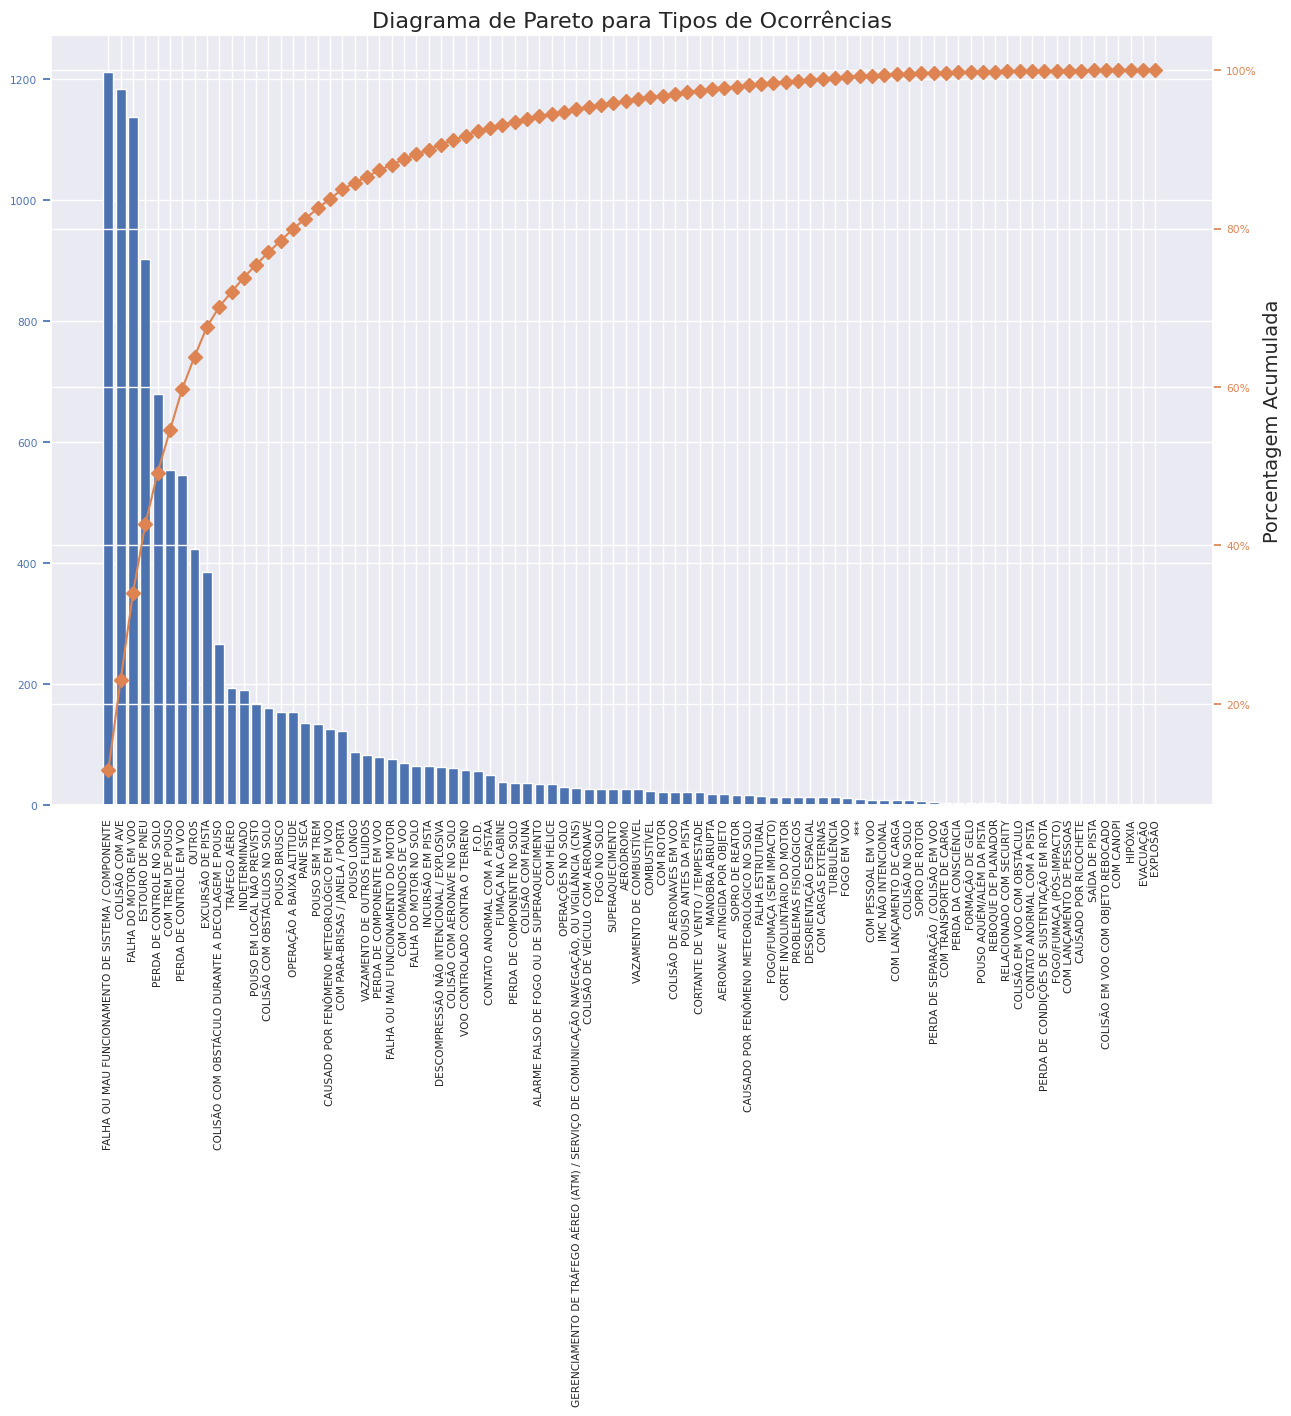

In [ ]:
# Ajustar a escala da fonte do gráfico
sbn.set(font_scale=0.7)

#Agrupar e contar ocorrências por tipo de ocorrência
oc_tipo = df.groupby('Tipo de ocorrência').size().reset_index(name='Número de Ocorrências')

# Passo 2: Ordenar os tipos de ocorrência por número de ocorrências
oc_tipo = oc_tipo.sort_values(by='Número de Ocorrências', ascending=False)

# Passo 3: Calcular a porcentagem acumulada
oc_tipo["Porcentagem Acumulada"] = oc_tipo['Número de Ocorrências'].cumsum() / oc_tipo['Número de Ocorrências'].sum() * 100

# Passo 4: Criar o gráfico de Pareto
fig, ax = plt.subplots(figsize=(15, 10))

# Barras para o número de ocorrências
ax.bar(oc_tipo['Tipo de ocorrência'], oc_tipo['Número de Ocorrências'], color="C0")

# Eixo y secundário para a linha de porcentagem acumulada
ax2 = ax.twinx()  # Criar um segundo eixo y para a linha de porcentagem
ax2.plot(oc_tipo['Tipo de ocorrência'], oc_tipo["Porcentagem Acumulada"], color="C1", marker="D", ms=7)

# Formatador para o eixo y da porcentagem
ax2.yaxis.set_major_formatter(PercentFormatter())

# Rótulos dos eixos
plt.title('Diagrama de Pareto para Tipos de Ocorrências', fontsize=16)
plt.xlabel('Tipo de Ocorrência', fontsize=14)
plt.ylabel('Número de Ocorrências', fontsize=14)
ax2.set_ylabel('Porcentagem Acumulada', fontsize=14)

# Ajustar a rotação dos rótulos do eixo X para facilitar a leitura
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

# Ajustar os eixos
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

# Exibir o gráfico
plt.show()


In [ ]:
oc_tipo.head(16)

,Tipo de ocorrência,Número de Ocorrências,Porcentagem Acumulada
43,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,1212,11.657209
8,COLISÃO COM AVE,1184,23.045109
40,FALHA DO MOTOR EM VOO,1137,33.980956
35,ESTOURO DE PNEU,902,42.656536
66,PERDA DE CONTROLE NO SOLO,680,49.196884
27,COM TREM DE POUSO,554,54.525344
65,PERDA DE CONTROLE EM VOO,545,59.767241
59,OUTROS,424,63.845340
37,EXCURSÃO DE PISTA,386,67.557949
10,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,267,70.125998


# **Análise descritiva dos dados**

In [ ]:
df.describe()

,Código da ocorrência,Latitude da ocorrência,Longitude da ocorrência,Código IBGE do município,Código IBGE da microrregião,Código IBGE da mesoregião,Código IBGE da UF,Código IBGE da região,Dia da ocorrência,Ano da ocorrência,...,Dia de divulgação da publicação,Total de recomendações,Total de aeronaves envolvidas,PMD aeronave,Categoria PMD aeronave,Quantidade de assentos,Ano de fabricação,Total de fatalidades,Ocorrências,Horário do Acidente
count,10397.000000,10397.000000,10397.000000,1.039700e+04,10397.000000,10397.000000,10397.000000,10397.000000,10397,10397.000000,...,10397,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000,10397.000000
mean,62441.940848,-18.392234,-48.115042,3.461259e+06,34487.253438,3452.180244,34.587670,3.127729,2016-04-27 09:13:43.737616640,2015.814947,...,1929-08-19 04:23:34.100221184,0.361354,1.022891,21161.756372,21161.756372,34.723670,1857.477253,0.145619,152.966144,14.888056
min,28256.000000,-884.917000,-72.787966,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2007-01-01 00:00:00,2007.000000,...,1900-01-02 00:00:00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,46306.000000,-23.404066,-51.227035,3.106200e+06,31018.000000,3105.000000,31.000000,3.000000,2011-10-25 00:00:00,2011.000000,...,1900-01-02 00:00:00,0.000000,1.000000,1270.000000,1270.000000,2.000000,1977.000000,0.000000,8.000000,12.100000
50%,65098.000000,-21.178000,-47.880612,3.516853e+06,35032.000000,3507.000000,35.000000,3.000000,2016-03-07 00:00:00,2016.000000,...,1900-01-02 00:00:00,0.000000,1.000000,2155.000000,2155.000000,6.000000,1992.000000,0.000000,60.000000,15.483333
75%,80090.000000,-13.553388,-44.210987,4.204202e+06,42008.000000,4202.000000,42.000000,4.000000,2021-05-09 00:00:00,2021.000000,...,2009-03-09 00:00:00,0.000000,1.000000,23000.000000,23000.000000,13.000000,2008.000000,0.000000,245.000000,19.083333
max,83097.000000,4.595018,0.000000,5.300108e+06,53001.000000,5301.000000,53.000000,5.000000,2023-12-31 00:00:00,2023.000000,...,2023-12-29 00:00:00,83.000000,4.000000,397000.000000,397000.000000,659.000000,9999.000000,199.000000,615.000000,23.983333
std,17456.408952,14.369120,6.962138,1.116616e+06,11160.267604,1116.051957,10.981005,1.191398,NaN,5.234625,...,NaN,1.586162,0.162510,39945.063114,39945.063114,64.004453,506.471969,2.066319,186.290510,5.525103


# **Análise da qualidade dos dados**

In [ ]:
# Contar valores faltantes por coluna
print(df.isnull().sum())

Código da ocorrência                   0
Classificação da ocorrência            0
Latitude da ocorrência                 0
Longitude da ocorrência                0
Código IBGE do município               0
Nome do município                      0
Código IBGE da microrregião            0
Nome da microrregiao                   0
Código IBGE da mesoregião              0
Nome da mesoregião                     0
Código IBGE da UF                      0
Sigla UF                               0
Unidade federativa                     0
Código IBGE da região                  0
Sigla da região                        0
Região                                 0
País da ocorrência                     0
Aeródromo da ocorrência                0
Dia da ocorrência                      0
Ano da ocorrência                      0
Hora da ocorrência                     0
Data e hora da ocorrência              0
Aeronave liberada da investigação    314
Status da investigação                 0
Número de divulg

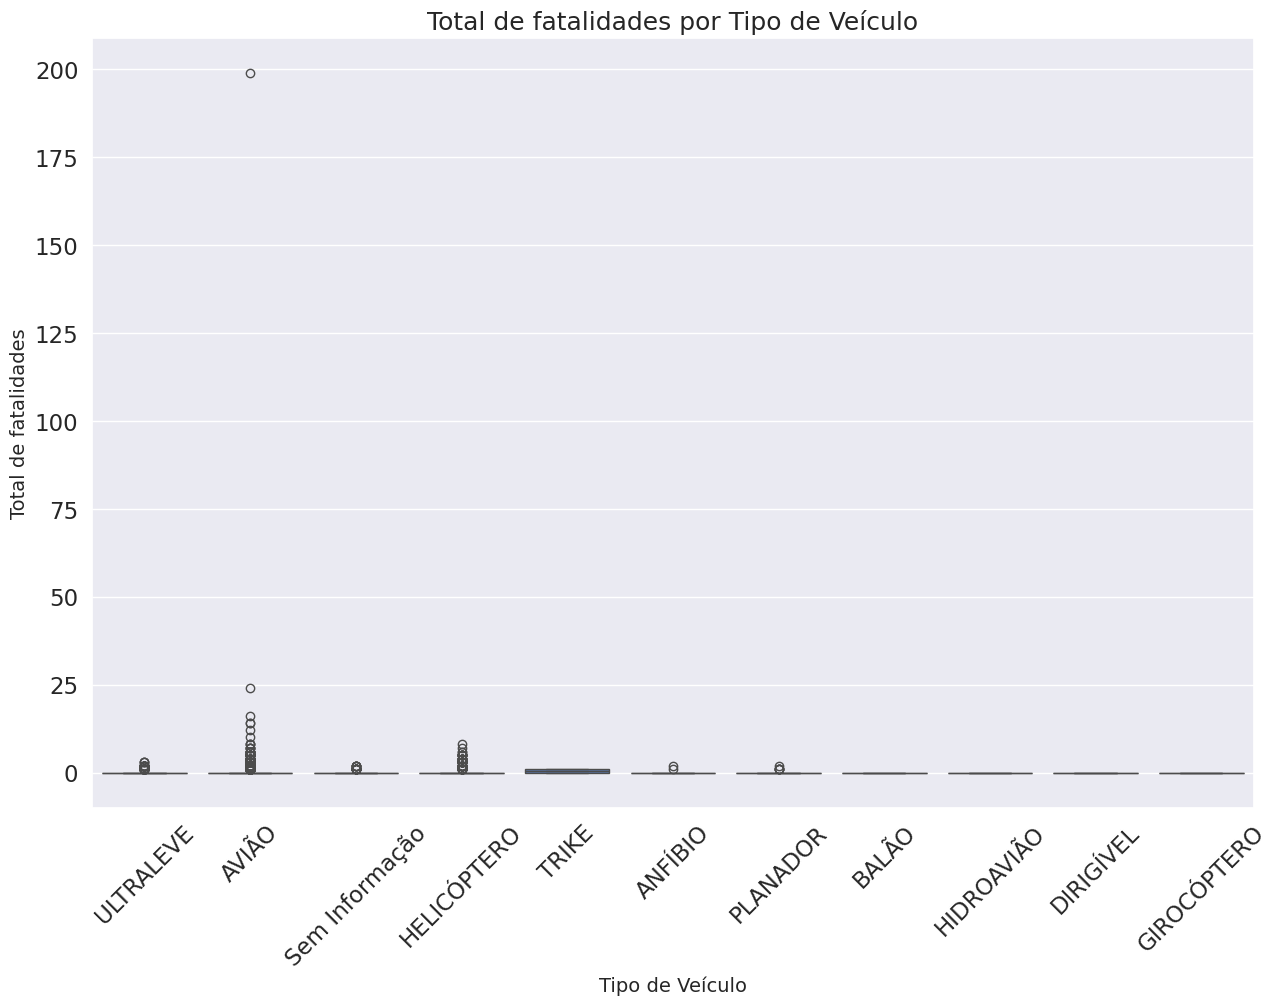

In [ ]:

plt.figure(figsize=(15,10))
sbn.set_style('whitegrid')
sbn.set(font_scale=1.5)
ax = sbn.boxplot(data=df, x='Tipo de veículo',
y='Total de fatalidades')
plt.title('Total de fatalidades por Tipo de Veículo', fontsize=18)
plt.xlabel('Tipo de Veículo', fontsize=14)
plt.ylabel('Total de fatalidades', fontsize=14)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()



Outliers encontrados:
 Empty DataFrame
Columns: [Código da ocorrência, Classificação da ocorrência, Latitude da ocorrência, Longitude da ocorrência, Código IBGE do município, Nome do município, Código IBGE da microrregião, Nome da microrregiao, Código IBGE da mesoregião, Nome da mesoregião, Código IBGE da UF, Sigla UF, Unidade federativa, Código IBGE da região, Sigla da região, Região, País da ocorrência, Aeródromo da ocorrência, Dia da ocorrência, Ano da ocorrência, Hora da ocorrência, Data e hora da ocorrência, Aeronave liberada da investigação, Status da investigação, Número de divulgação do relatório, Divulgação do relatório publicado, Dia de divulgação da publicação, Total de recomendações, Total de aeronaves envolvidas, Ocorrência de saída da pista, Matrícula da aeronave, Categoria do operador da aeronave, Tipo de veículo, Fabricante da aeronave, Modelo da aeronave, Tipo de operação da aeronave, Tipo de icao da aeronave, Tipo de motor da aeronave, Quantidade de motores da aeronav

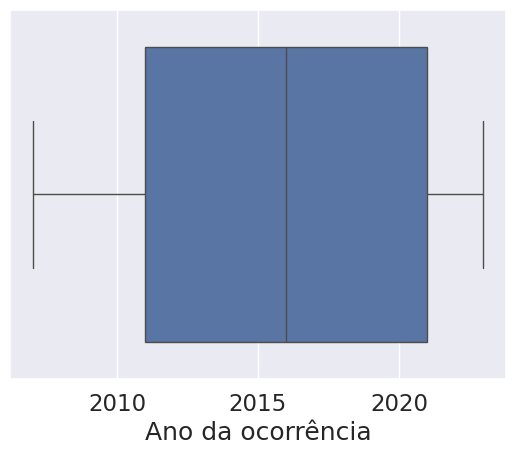

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Ano da ocorrência'].quantile(0.25)
Q3 = df['Ano da ocorrência'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Ano da ocorrência'] < limite_inferior) | (df['Ano da ocorrência'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Ano da ocorrência'])
plt.show()

# Remover outliers
df = df[~((df['Ano da ocorrência'] < limite_inferior) | (df['Ano da ocorrência'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
3                     38855                    ACIDENTE   
4                     50831                    ACIDENTE   
11                    52838                    ACIDENTE   
19                    46437                    ACIDENTE   
37                    46916                    ACIDENTE   
...                     ...                         ...   
10274                 46710                    ACIDENTE   
10278                 81852                    ACIDENTE   
10283                 53579                    ACIDENTE   
10292                 78717                    ACIDENTE   
10382                 37357                    ACIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
3                  -31.867518               -54.163801   
4                  -17.400018               -50.379307   
11                 -14.053066               -52.164185   
19                 -20.448000       

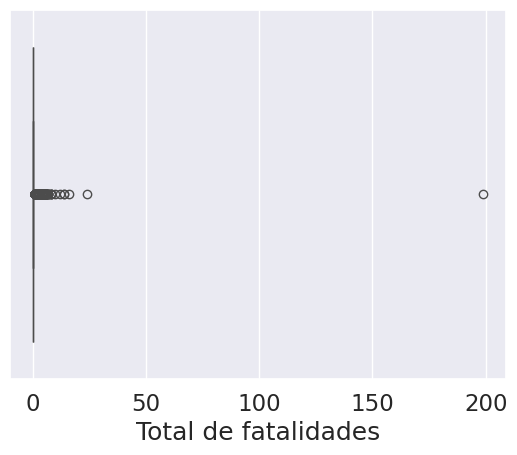

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de fatalidades'].quantile(0.25)
Q3 = df['Total de fatalidades'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de fatalidades'] < limite_inferior) | (df['Total de fatalidades'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de fatalidades'])
plt.show()

# Remover outliers
df = df[~((df['Total de fatalidades'] < limite_inferior) | (df['Total de fatalidades'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
0                     78640                    ACIDENTE   
13                    80333                   INCIDENTE   
29                    77731                    ACIDENTE   
33                    45913                    ACIDENTE   
43                    66522                    ACIDENTE   
...                     ...                         ...   
10342                 45943                   INCIDENTE   
10348                 81043                   INCIDENTE   
10359                 81116                   INCIDENTE   
10360                 81116                   INCIDENTE   
10396                 43729                    ACIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
0                  -16.762062               -49.438403   
13                 -14.053066               -52.164185   
29                 -29.645000               -53.240000   
33                  -2.406669       

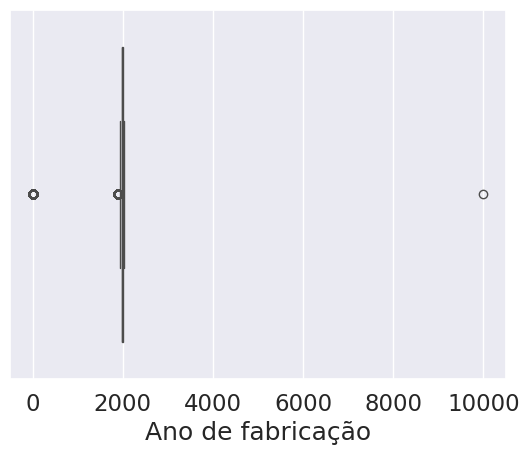

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Ano de fabricação'].quantile(0.25)
Q3 = df['Ano de fabricação'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Ano de fabricação'] < limite_inferior) | (df['Ano de fabricação'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Ano de fabricação'])
plt.show()

# Remover outliers
df = df[~((df['Ano de fabricação'] < limite_inferior) | (df['Ano de fabricação'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
27                    49474                    ACIDENTE   
28                    36604                   INCIDENTE   
49                    48757                   INCIDENTE   
60                    44917                   INCIDENTE   
77                    43899                    ACIDENTE   
...                     ...                         ...   
10383                 82604                   INCIDENTE   
10384                 77641                   INCIDENTE   
10385                 42386                    ACIDENTE   
10386                 42386                    ACIDENTE   
10387                 53004                   INCIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
27                   0.000000                 0.000000   
28                   0.000000                 0.000000   
49                 -20.637309               -40.748830   
60                  -9.871723       

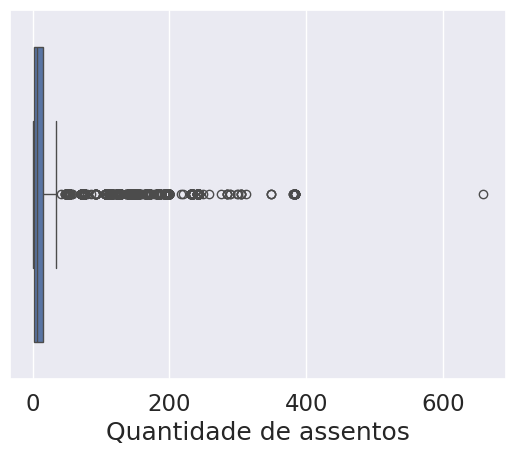

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Quantidade de assentos'].quantile(0.25)
Q3 = df['Quantidade de assentos'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Quantidade de assentos'] < limite_inferior) | (df['Quantidade de assentos'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Quantidade de assentos'])
plt.show()

# Remover outliers
df = df[~((df['Quantidade de assentos'] < limite_inferior) | (df['Quantidade de assentos'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
142                   61014             INCIDENTE GRAVE   
146                   61014             INCIDENTE GRAVE   
159                   47245                   INCIDENTE   
163                   47245                   INCIDENTE   
180                   51433                    ACIDENTE   
...                     ...                         ...   
10009                 52614                   INCIDENTE   
10293                 77832                   INCIDENTE   
10302                 77832                   INCIDENTE   
10355                 81116                   INCIDENTE   
10357                 81116                   INCIDENTE   

       Latitude da ocorrência  Longitude da ocorrência  \
142                  3.652152               -61.419385   
146                  3.652152               -61.419385   
159                -22.739000               -47.331000   
163                -22.739000       

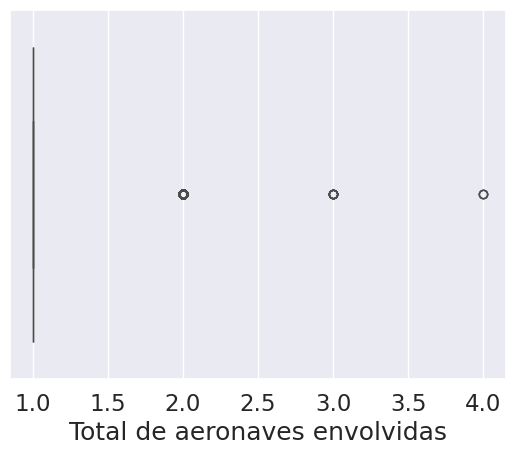

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de aeronaves envolvidas'].quantile(0.25)
Q3 = df['Total de aeronaves envolvidas'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de aeronaves envolvidas'] < limite_inferior) | (df['Total de aeronaves envolvidas'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de aeronaves envolvidas'])
plt.show()

# Remover outliers
df = df[~((df['Total de aeronaves envolvidas'] < limite_inferior) | (df['Total de aeronaves envolvidas'] > limite_superior))]

Outliers encontrados:
        Código da ocorrência Classificação da ocorrência  \
9                     42071                    ACIDENTE   
14                    79131                    ACIDENTE   
18                    36097             INCIDENTE GRAVE   
23                    44464                    ACIDENTE   
24                    53628                    ACIDENTE   
...                     ...                         ...   
10273                 77653                    ACIDENTE   
10279                 79231                    ACIDENTE   
10287                 80311                    ACIDENTE   
10296                 43998             INCIDENTE GRAVE   
10393                 80238             INCIDENTE GRAVE   

       Latitude da ocorrência  Longitude da ocorrência  \
9                   -0.157282               -50.390247   
14                 -14.053066               -52.164185   
18                  -5.891845               -42.634111   
23                 -20.448000       

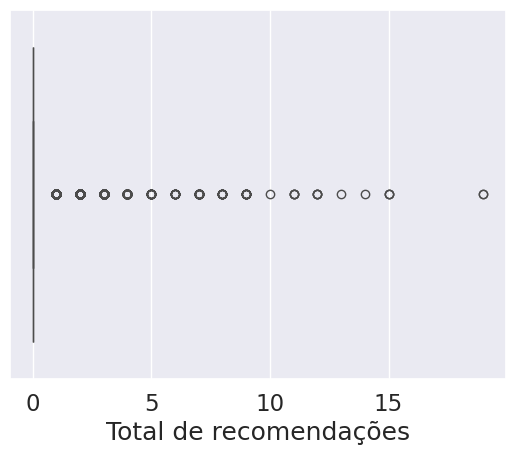

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Total de recomendações'].quantile(0.25)
Q3 = df['Total de recomendações'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Total de recomendações'] < limite_inferior) | (df['Total de recomendações'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Total de recomendações'])
plt.show()

# Remover outliers
df = df[~((df['Total de recomendações'] < limite_inferior) | (df['Total de recomendações'] > limite_superior))]

Outliers encontrados:
 Empty DataFrame
Columns: [Código da ocorrência, Classificação da ocorrência, Latitude da ocorrência, Longitude da ocorrência, Código IBGE do município, Nome do município, Código IBGE da microrregião, Nome da microrregiao, Código IBGE da mesoregião, Nome da mesoregião, Código IBGE da UF, Sigla UF, Unidade federativa, Código IBGE da região, Sigla da região, Região, País da ocorrência, Aeródromo da ocorrência, Dia da ocorrência, Ano da ocorrência, Hora da ocorrência, Data e hora da ocorrência, Aeronave liberada da investigação, Status da investigação, Número de divulgação do relatório, Divulgação do relatório publicado, Dia de divulgação da publicação, Total de recomendações, Total de aeronaves envolvidas, Ocorrência de saída da pista, Matrícula da aeronave, Categoria do operador da aeronave, Tipo de veículo, Fabricante da aeronave, Modelo da aeronave, Tipo de operação da aeronave, Tipo de icao da aeronave, Tipo de motor da aeronave, Quantidade de motores da aeronav

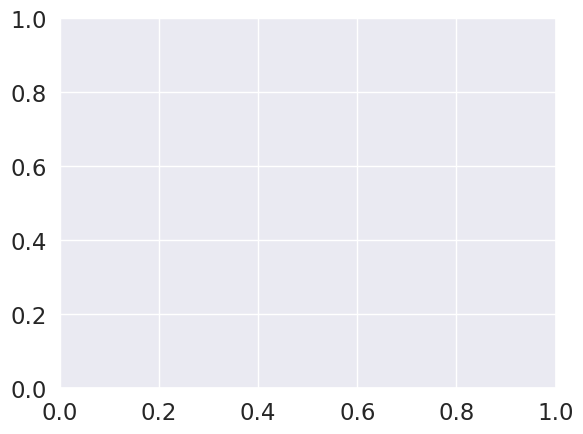

In [ ]:
# Identificar outliers com o método do IQR
Q1 = df['Data e hora da ocorrência'].quantile(0.25)
Q3 = df['Data e hora da ocorrência'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df[(df['Data e hora da ocorrência'] < limite_inferior) | (df['Data e hora da ocorrência'] > limite_superior)]
print("Outliers encontrados:\n", outliers)

# Boxplot para visualizar outliers
sbn.boxplot(x=df['Data e hora da ocorrência'])
plt.show()

# Remover outliers
df = df[~((df['Data e hora da ocorrência'] < limite_inferior) | (df['Data e hora da ocorrência'] > limite_superior))]

# **Teste do qui-quadrado**

Tabela de Contingência:
Classificação da ocorrência      ACIDENTE  INCIDENTE  INCIDENTE GRAVE
Fase de operação                                                     
APROXIMAÇÃO FINAL                     115        442               48
ARREMETIDA NO AR                       23         16                9
ARREMETIDA NO SOLO                     36         26               14
CHEQUE DE MOTOR OU ROTOR                3         11                0
CIRCUITO DE TRÁFEGO                    68        108               13
CORRIDA APÓS POUSO                    252        566              259
CRUZEIRO                              393        853              156
DECOLAGEM                             566       1025              171
DECOLAGEM VERTICAL                      8          8                2
DESCIDA                                58        235               22
DESCIDA DE EMERGÊNCIA                   1          1                1
DESCIDA DESCONTROLADA                   1          0              

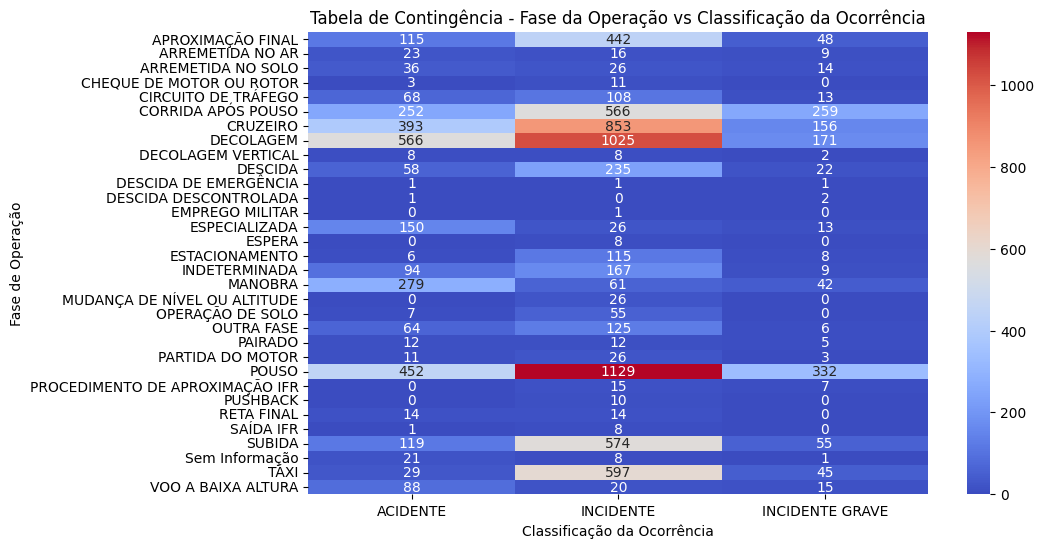

In [ ]:
from scipy.stats import chi2_contingency
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Fase de operação'], df['Classificação da ocorrência'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Fase da Operação e a Classificação da Ocorrência.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Fase da Operação e a Classificação da Ocorrência.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Fase da Operação vs Classificação da Ocorrência')
plt.xlabel('Classificação da Ocorrência')
plt.ylabel('Fase de Operação')
plt.show()

In [ ]:
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Fase de operação'], df['Tipo de veículo'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Fase da Operação e a Tipo de veículo.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Fase da Operação e a Tipo de veículo.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Fase da Operação vs Tipo de veículo')
plt.xlabel('Tipo de veículo')
plt.ylabel('Fase de Operação')
plt.show()

In [ ]:
# Criar a tabela de contingência
tabela_contingencia = pd.crosstab(df['Classificação da ocorrência'], df['Tipo de veículo'])
# Exibir a tabela de contingência
print("Tabela de Contingência:")
print(tabela_contingencia)

# Realizar o teste qui-quadrado
chi2, p_valor, dof, esperados = chi2_contingency(tabela_contingencia)

# Exibir os resultados
print("\nResultados do Teste Qui-Quadrado:")
print(f"Qui-quadrado: {chi2}")
print(f"Valor p: {p_valor}")
print(f"Graus de liberdade: {dof}")
print("Tabela Esperada:")
print(pd.DataFrame(esperados, columns=tabela_contingencia.columns, index=tabela_contingencia.index))

# Interpretação do valor p
if p_valor < 0.05:
    print("\nRejeitamos a hipótese nula. Existe uma associação significativa entre a Classificação da ocorrência e a Tipo de veículo.")
else:
    print("\nNão rejeitamos a hipótese nula. Não há associação significativa entre a Classificação da ocorrência e a Tipo de veículo.")

# Visualização com heatmap
plt.figure(figsize=(10, 6))
sbn.heatmap(tabela_contingencia, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Tabela de Contingência - Classificação da ocorrência vs Tipo de veículo')
plt.xlabel('Tipo de veículo')
plt.ylabel('Classificação da ocorrência')
plt.show()

Tabela de Contingência:
Empty DataFrame
Columns: []
Index: []


ValueError: No data; `observed` has size 0.

# **Regressão Linear**

Correlação entre X e Y: 0.02469782851261619
MAE: 0.2452221767282296
MSE: 0.2938704308023962
R²: -0.015724001811498134


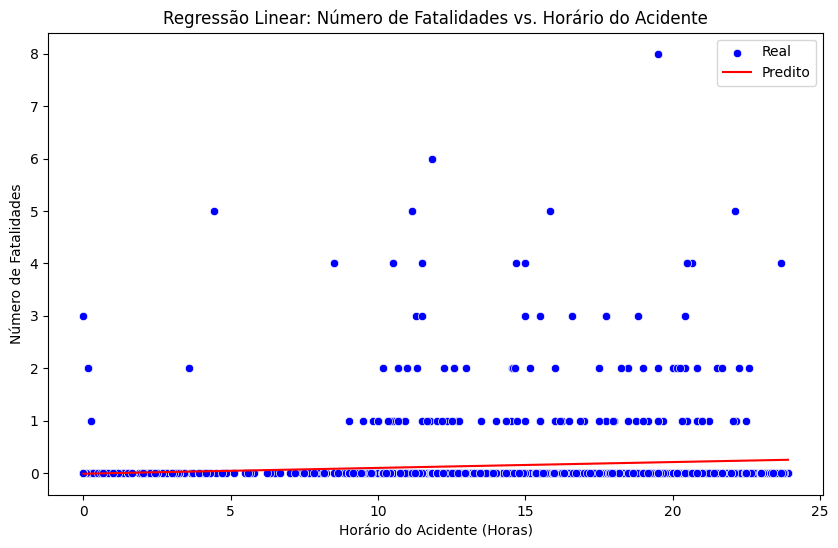

Previsão para acidente às 14h30: 0.1498642331335617 fatalidades
Pré-processamento, análise de correlação e regressão linear concluídos.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
# Definir variáveis X e Y
X = df[['Horário do Acidente']]
y = df['Total de fatalidades']

# Cálculo da correlação entre X e Y
correlacao = np.corrcoef(X.values.ravel(), y)
print(f'Correlação entre X e Y: {correlacao[0,1]}')

# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- ETAPA 2: TREINAMENTO DO MODELO ----
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# ---- ETAPA 3: AVALIAÇÃO DO MODELO ----
y_pred = modelo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

# ---- ETAPA 4: VISUALIZAÇÃO ----
plt.figure(figsize=(10, 6))
sbn.scatterplot(x=X_test['Horário do Acidente'], y=y_test, label='Real', color='blue')
sbn.lineplot(x=X_test['Horário do Acidente'], y=y_pred, label='Predito', color='red')
plt.title('Regressão Linear: Número de Fatalidades vs. Horário do Acidente')
plt.xlabel('Horário do Acidente (Horas)')
plt.ylabel('Número de Fatalidades')
plt.legend()
plt.show()

# ---- ETAPA 5: TESTE DE PREVISÃO ----
# Exemplo: previsão para um acidente ocorrido às 14h30 (14.5 horas)
predicao_14_5 = modelo.predict([[14.5]])
print(f'Previsão para acidente às 14h30: {predicao_14_5[0]} fatalidades')

print("Pré-processamento, análise de correlação e regressão linear concluídos.")

# **Floresta aleatória**

In [16]:
# Importando bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

# Selecionar variáveis preditoras (X) e variável alvo (y)
X = df[['Tipo de veículo', 'Fase de operação']]  # Variáveis preditoras
y = df['Classificação da ocorrência']  # Variável alvo

# Transformar variáveis categóricas em números
encoder = LabelEncoder()
X = X.apply(encoder.fit_transform)  # Converte todas as colunas categóricas
y = encoder.fit_transform(y)  # Converte a variável alvo

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar o modelo de Árvore de Decisão
arvore = DecisionTreeClassifier(random_state=42)
arvore.fit(X_train, y_train)

# Fazer previsões
y_pred_arvore = arvore.predict(X_test)

# Avaliação do modelo - Árvore de Decisão
print("Matriz de Confusão - Árvore de Decisão:")
print(confusion_matrix(y_test, y_pred_arvore))
print("\nRelatório de Classificação - Árvore de Decisão:")
print(classification_report(y_test, y_pred_arvore))

# Acurácia da Árvore de Decisão
accuracy_arvore = accuracy_score(y_test, y_pred_arvore)
print(f"Acurácia da Árvore de Decisão: {accuracy_arvore:.4f}")

# Treinar o modelo de Floresta Aleatória
floresta = RandomForestClassifier(n_estimators=100, random_state=42)
floresta.fit(X_train, y_train)

# Fazer previsões
y_pred_floresta = floresta.predict(X_test)

# Avaliação do modelo - Floresta Aleatória
print("\nMatriz de Confusão - Floresta Aleatória:")
print(confusion_matrix(y_test, y_pred_floresta))
print("\nRelatório de Classificação - Floresta Aleatória:")
print(classification_report(y_test, y_pred_floresta))

# Acurácia da Floresta Aleatória
accuracy_floresta = accuracy_score(y_test, y_pred_floresta)
print(f"Acurácia da Floresta Aleatória: {accuracy_floresta:.4f}")



Matriz de Confusão - Árvore de Decisão:
[[ 234  576    0]
 [  71 1874    2]
 [  53  308    2]]

Relatório de Classificação - Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.65      0.29      0.40       810
           1       0.68      0.96      0.80      1947
           2       0.50      0.01      0.01       363

    accuracy                           0.68      3120
   macro avg       0.61      0.42      0.40      3120
weighted avg       0.65      0.68      0.60      3120

Acurácia da Árvore de Decisão: 0.6763

Matriz de Confusão - Floresta Aleatória:
[[ 227  583    0]
 [  64 1882    1]
 [  53  308    2]]

Relatório de Classificação - Floresta Aleatória:
              precision    recall  f1-score   support

           0       0.66      0.28      0.39       810
           1       0.68      0.97      0.80      1947
           2       0.67      0.01      0.01       363

    accuracy                           0.68      3120
   macro avg      

# **Regressão Logística**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
X = df[["Tipo de veículo", "Fase de operação"]]
y = df["Classificação da ocorrência"]

# Transformação das variáveis categóricas
for col in X.columns:
    X[col] = LabelEncoder().fit_transform(X[col])

y = LabelEncoder().fit_transform(y)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar a regressão logística multinomial
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
log_reg.fit(X_train, y_train)

# Fazer previsões
y_pred = log_reg.predict(X_test)

# Avaliação do modelo
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.14      0.22       533
           1       0.64      0.95      0.77      1296
           2       0.00      0.00      0.00       251

    accuracy                           0.63      2080
   macro avg       0.37      0.36      0.33      2080
weighted avg       0.52      0.63      0.53      2080

[[  75  458    0]
 [  61 1235    0]
 [  24  227    0]]


<ipython-input-11-543ce510f0c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
<ipython-input-11-543ce510f0c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this

Coeficientes: [[ 0.09175217 -0.00581294]
 [-0.08988553  0.0088768 ]
 [-0.00186664 -0.00306386]]
Intercepto: [-0.09257563  0.85296142 -0.76038579]


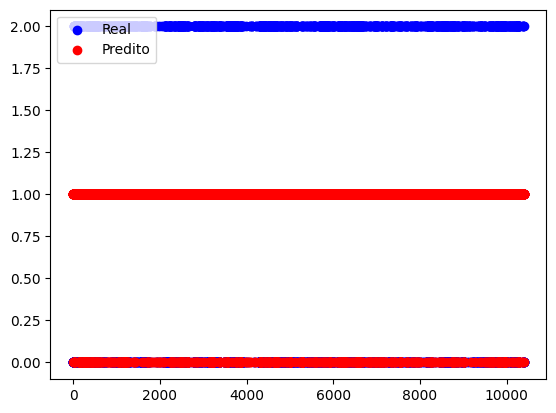

FileNotFoundError: [Errno 2] No such file or directory: 'NovosCandidatos.csv'

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Transformação das variáveis categóricas em numéricas
from sklearn.preprocessing import LabelEncoder

# Supondo que df seja o seu dataframe com as colunas 'Tipo de veículo', 'Fase de operação', 'Classificação da ocorrência'
le = LabelEncoder()
df['Tipo de veículo'] = le.fit_transform(df['Tipo de veículo'])
df['Fase de operação'] = le.fit_transform(df['Fase de operação'])
df['Classificação da ocorrência'] = le.fit_transform(df['Classificação da ocorrência'])

# Definir as variáveis independentes (X) e dependente (y)
X = df[['Tipo de veículo', 'Fase de operação']].values  # Tipo de veículo e Fase de operação como variáveis preditoras
y = df['Classificação da ocorrência'].values  # Classificação da ocorrência como variável alvo

# Criação do modelo de regressão logística
modelo = LogisticRegression(max_iter=1000)  # Ajuste do número de iterações para garantir a convergência
modelo.fit(X, y)

# Coeficientes e intercepto
print("Coeficientes:", modelo.coef_)
print("Intercepto:", modelo.intercept_)

# Visualizar as previsões
y_pred = modelo.predict(X)

# Visualização das previsões vs. valores reais
plt.scatter(range(len(y)), y, color='blue', label='Real')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predito')
plt.legend()
plt.show()

# Geração de novas previsões para um conjunto de dados de novos candidatos
base_previsoes = pd.read_csv('NovosCandidatos.csv', sep=';')

# Transformação dos dados dos novos candidatos
X_novos = base_previsoes[['Tipo de veículo', 'Fase de operação']].values  # Considerando as mesmas colunas
previsoes_teste = modelo.predict(X_novos)

# Adicionar as previsões à base de dados original
base_previsoes['Classificação prevista'] = previsoes_teste

# Exibir a base de dados com as previsões
print(base_previsoes)


# **Rede neural**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

# Transformar variáveis categóricas em numéricas
le = LabelEncoder()
df['Tipo de veículo'] = le.fit_transform(df['Tipo de veículo'])
df['Fase de operação'] = le.fit_transform(df['Fase de operação'])
df['Classificação da ocorrência'] = le.fit_transform(df['Classificação da ocorrência'])

# Criar conjunto de dados com as variáveis preditoras e a variável alvo
df = df[['Tipo de veículo', 'Fase de operação', 'Classificação da ocorrência']]

# Normalizar os dados
sc = StandardScaler()
df[['Tipo de veículo', 'Fase de operação']] = sc.fit_transform(df[['Tipo de veículo', 'Fase de operação']])

# Dividir os dados em conjunto de treinamento e validação
training_set, validation_set = train_test_split(df, test_size=0.2, random_state=21)

X_train = training_set.iloc[:, :-1].values
Y_train = training_set.iloc[:, -1].values
X_val = validation_set.iloc[:, :-1].values
y_val = validation_set.iloc[:, -1].values

# Definir função para calcular acurácia
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements

# Criar e treinar a rede neural
classifier = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, activation='relu', solver='adam', random_state=1)
classifier.fit(X_train, Y_train)

# Fazer previsões
y_pred = classifier.predict(X_val)

# Calcular matriz de confusão e acurácia
cm = confusion_matrix(y_pred, y_val)
print("Matriz de Confusão:\n", cm)
print("Acurácia da Rede Neural:", accuracy(cm))


<ipython-input-18-4048a3d2d14e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Tipo de veículo', 'Fase de operação']] = sc.fit_transform(df[['Tipo de veículo', 'Fase de operação']])


Matriz de Confusão:
 [[ 156   39   43]
 [ 394 1237  211]
 [   0    0    0]]
Acurácia da Rede Neural: 0.6697115384615384
